<a href="https://github.com/carlosarroyave/Face_keras/blob/master/utility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This file contains functions for inference phase

import numpy as np
import cv2
from umeyama import umeyama
import tensorflow as tf

def get_tar_landmarks(img, landmarks_type=68):
    """    
    img: detected face image
    """         
    img_sz = img.shape
    if landmarks_type == 68:
        avg_landmarks = np.array(
            [[0.30366492, 0.02105263], [0.43979058, 0.02105263], [0.54450262, 0.03684211], [0.64921466, 0.06842105], [0.7539267 , 0.1       ], 
             [0.84816754, 0.15789474], [0.90575916, 0.22105263], [0.97905759, 0.32631579], [1.0104712 , 0.46315789], [0.97905759, 0.61052632], 
             [0.92146597, 0.73157895], [0.85863874, 0.81052632], [0.76963351, 0.86842105], [0.66492147, 0.9       ], [0.56020942, 0.91578947], 
             [0.45549738, 0.93157895], [0.33507853, 0.94736842], [0.27225131, 0.11578947], [0.2565445 , 0.17368421], [0.2565445 , 0.23684211], 
             [0.2565445 , 0.29473684], [0.28795812, 0.34210526], [0.28795812, 0.56842105], [0.27225131, 0.62631579], [0.27225131, 0.68947368], 
             [0.27225131, 0.76315789], [0.28795812, 0.82631579], [0.40837696, 0.46315789], [0.4973822 , 0.46315789], [0.57591623, 0.44736842], 
             [0.63350785, 0.44736842], [0.64921466, 0.36842105], [0.66492147, 0.4       ], [0.68062827, 0.46315789], [0.66492147, 0.50526316], 
             [0.64921466, 0.53684211], [0.36649215, 0.20526316], [0.35078534, 0.23684211], [0.36649215, 0.29473684], [0.37696335, 0.34210526], 
             [0.39267016, 0.29473684], [0.39267016, 0.23684211], [0.39267016, 0.58421053], [0.36649215, 0.62631579], [0.36649215, 0.68947368], 
             [0.37696335, 0.73157895], [0.40837696, 0.68947368], [0.40837696, 0.62631579], [0.7382199 , 0.26315789], [0.7382199 , 0.32631579], 
             [0.72774869, 0.41578947], [0.7382199 , 0.46315789], [0.7382199 , 0.48947368], [0.7382199 , 0.6       ], [0.7539267 , 0.67368421], 
             [0.83246073, 0.6       ], [0.85863874, 0.52105263], [0.87434555, 0.46315789], [0.85863874, 0.38421053], [0.81675393, 0.32631579], 
             [0.7382199 , 0.27894737], [0.7539267 , 0.38421053], [0.76963351, 0.46315789], [0.76963351, 0.52105263], [0.7539267 , 0.65789474], 
             [0.81675393, 0.52105263], [0.81675393, 0.46315789], [0.81675393, 0.38421053]]
        )
    else:
        raise NotImplementedError(f"Only 68 points landmarks model is provided. Received {landmarks_pnts}.")
    tar_landmarks = [(int(xy[0]*img_sz[0]), int(xy[1]*img_sz[1])) for xy in avg_landmarks]
    return tar_landmarks

def landmarks_match(src_im, src_landmarks, tar_landmarks, border_mode=cv2.BORDER_REPLICATE, border_value=(0,255,0)): 
    """
    umeyama(src, dst, estimate_scale), 
    src/dst landmarks coord. should be (y, x)
    """
    src_size = src_im.shape
    src_tmp = [(int(xy[1]), int(xy[0])) for xy in src_landmarks]
    dst_tmp = [(int(xy[1]), int(xy[0])) for xy in tar_landmarks]
    if len(src_tmp) >= 68:
        src_tmp = src_tmp[17:]
    if len(dst_tmp) >= 68:
        dst_tmp = dst_tmp[17:]
    M = umeyama(np.array(src_tmp), np.array(dst_tmp), True)[0:2]
    result = cv2.warpAffine(src_im, M, (src_size[1], src_size[0]), borderMode=border_mode, borderValue=border_value)
    return result, M     
        
def get_68_landmarks_edge_image(img, face, lms, eyes_binary_mask=False, apply_dilate_or_erode=True):
    result = np.zeros_like(img, np.uint8)
    stroke_size = np.maximum(np.min(face.shape[:2])//50, 2)    
        
    # nose
    for i in range(27,30):
        x0, y0 = int(lms[i][0]), int(lms[i][1])
        x1, y1 = int(lms[i+1][0]), int(lms[i+1][1])
        result = cv2.line(result.copy(), (y0, x0), (y1, x1), (255,255,0), stroke_size*2)
    return result
  
def vis_parsing_maps(im, parsing_anno, stride=1):
    # Colors for all 20 parts
    part_colors = [
        [255, 0, 0], [0, 0, 255], [0, 255, 255], [0, 255, 255], [255, 255, 255], 
        [255, 255, 255], [255, 85, 0], [170, 255, 0], [0, 255, 85], [0, 255, 170], 
        [0, 255, 0], [255, 125, 0], [255, 0, 125], [255, 75, 125], [0, 170, 255], 
        [200, 200, 45], [255, 255, 85],  [255, 255, 170], [255, 0, 255], 
        [255, 85, 255], [255, 170, 255], [255, 170, 0], [85, 255, 255], 
        [170, 255, 255]
    ]
    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3))# + 255
    num_of_class = np.max(vis_parsing_anno)

    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]
    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.4, vis_parsing_anno_color, 0.6, 0)
    return vis_parsing_anno_color

def detect_face(im, fd, with_landmarks=True):
    def get_square_bbox(x0, x1, y0, y1, input_img):
        center = np.array([(x0 + x1)/2, (y0 + y1)/2])
        length = (x1-x0 + y1-y0) / 2
        if ((center - length//2) < 0).any():
            return x0, x1, y0, y1
        if ((center + length//2) > input_img.shape[:2]).any():
            return x0, x1, y0, y1
        return center[0]-length/2, center[0]+length/2, center[1]-length/2, center[1]+length/2
    landmarks = None
    if with_landmarks: 
        bboxes, landmarks = fd.detect_face(im, with_landmarks=with_landmarks)
    else:
        bboxes = fd.detect_face(im, with_landmarks=with_landmarks)
    assert len(bboxes) >=1, "No face detected."
    if len(bboxes) > 1:
        print("Multiple faces detected. Only the most confident face will be processed.")
        most_conf_idx = sorted(
            range(len(bboxes)), 
            key=lambda idx: bboxes[idx][-1], 
            reverse=True)[0]
        bboxes = [bboxes[most_conf_idx]]
        try:
            landmarks = [landmarks[most_conf_idx]]
        except:
            pass
    x0, y0, x1, y1 = bboxes[0][:-1].astype(np.int32)
    x0, y0, x1, y1 = map(np.int32, get_square_bbox(x0, y0, x1, y1, im))
    return (x0, y0, x1, y1), landmarks
  
def align_image(im, x0, y0, x1, y1, landmarks):
    lms_tar = get_tar_landmarks(im[x0:x1, y0:y1, :], 68)
    aligned_img, M = landmarks_match(
        im, 
        landmarks[0], np.array(lms_tar)+[x0,y0], 
        border_mode=cv2.BORDER_CONSTANT, 
        border_value=(0,0,0))
    return aligned_img
  
def get_segm_mask(im, face_im, x0, y0, x1, y1, landmarks):    
    seg_mask = get_68_landmarks_edge_image(
        im, 
        face_im, 
        landmarks[0],
        apply_dilate_or_erode=False)
    seg_mask = seg_mask[int(x0):int(x1), int(y0):int(y1), :] 
    return seg_mask
  
def parse_face(im, seg_mask, fp):
    parsing_map = fp.parse_face(im)
    colored_parsing_map = vis_parsing_maps(im, parsing_map[0])
    nose_tip_mask = np.prod(seg_mask==(255,255,0), axis=-1)[...,None]
    colored_parsing_map = (1-nose_tip_mask) * colored_parsing_map + nose_tip_mask * seg_mask
    return colored_parsing_map
  
def get_eyes_mask(colored_parsing_map):
    return np.prod(colored_parsing_map == (255,255,255), axis=-1)[...,None]
  
def detect_irises(im, idet, landmarks2=None):
    eye_lms = idet.detect_iris(im, landmarks2)
    return eye_lms
  
def draw_irises(colored_parsing_map, eyes_mask, eyes_lms):
    parsing_map_with_iris = colored_parsing_map.copy()
    for lms in eyes_lms[0]:
        parsing_map_with_iris = cv2.fillPoly(
            parsing_map_with_iris.astype(np.int32), 
            [lms[8:16, ::-1].reshape(-1,1,2).astype(np.int32)], 
            color=(125,125,125)) 
    parsing_map_with_iris = (1 - eyes_mask) * colored_parsing_map\
    + eyes_mask * parsing_map_with_iris
    return parsing_map_with_iris

def auto_resize(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        im = cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

def get_src_inputs(fn, fd, fp, idet):
    """
    Inputs:
        fn: A string. Path to a image file.
        fd: An instance of FaceAlignmentDetector. Face detector in face_toolbox_keras. 
        fp: An instance of FaceParer. Face parsing model in face_toolbox_keras.
    Outputs:
        aligned_face: A RGB image. Aligned face image.
        parsing_map_with_iris:  A RGB image.
        aligned_im: A RGB image. Aligned raw input image.
        (x0, y0, x1, y1), A tuple of integers. Bounding box coordinates.
        landmarks: A numpy array of shape (68,2). 68-points face landmarks.
    """
    im = cv2.imread(fn)[..., ::-1]
    im = auto_resize(im)
    (x0, y0, x1, y1), landmarks = detect_face(im, fd)
    aligned_im = align_image(im, x0, y0, x1, y1, landmarks)
    
    # Apply detection & alignment twice for better face alignment result.
    (x0, y0, x1, y1), landmarks2 = detect_face(aligned_im, fd)
    aligned_face = aligned_im[x0:x1, y0:y1, :].copy()
    
    segm_mask = get_segm_mask(aligned_im, aligned_face, x0, y0, x1, y1, landmarks2)
    
    colored_parsing_map = parse_face(aligned_face, segm_mask, fp=fp)
    eyes_mask = get_eyes_mask(colored_parsing_map)
    
    eyes_lms = detect_irises(aligned_im, idet, landmarks2)
    eyes_lms = eyes_lms - np.array([[[x0, y0]]])
    parsing_map_with_iris = draw_irises(colored_parsing_map, eyes_mask, eyes_lms)
    return aligned_face, parsing_map_with_iris, aligned_im, (x0, y0, x1, y1), landmarks
  
def get_tar_inputs(fns, fd, fv):
    """
    Inputs:
        fn: A string or a list. Path to a image file(s).
        fd: An instance of FaceAlignmentDetector. Face detector in face_toolbox_keras. 
        fv: An instance of FaceVerifier. Face verificaiton model in face_toolbox_keras.
    Outputs:
        aligned_face: A RGB image.
        emb_tar: A numpy array of shape (512,). Latent embeddings of aligned_face.
    """
    if not type(fns) == list:
        if type(fns) == str:
            fns = [fns]
        else:
            raise ValueError("Received and unknown filename type. fns shoulbe be a list or a string.")
    emb_avg_tar = np.zeros((1, 512))
    for fn in fns:
        im = cv2.imread(fn)[..., ::-1]
        im = auto_resize(im)
        (x0, y0, x1, y1), landmarks = detect_face(im, fd)
        aligned_im = align_image(im, x0, y0, x1, y1, landmarks)    
        (x0, y0, x1, y1), landmarks2 = detect_face(aligned_im, fd, with_landmarks=False)
        aligned_face = aligned_im[x0:x1, y0:y1, :].copy()
        emb_tar = fv.extract_embeddings(aligned_face)
        emb_avg_tar += emb_tar
    emb_avg_tar /= len(fns)
    return aligned_face, emb_avg_tar

def get_feather_blend_mask(im):
    fb_mask = np.zeros_like(im)
    fb_mask[
        fb_mask.shape[0]//10:-fb_mask.shape[0]//10, 
        fb_mask.shape[1]//10:-fb_mask.shape[1]//10] = 255
    kernel_size = np.max(fb_mask.shape)//12//2 * 2 + 1
    fb_mask = cv2.GaussianBlur(fb_mask, (kernel_size,kernel_size), 0)
    return fb_mask

def post_process_result(fn, fd, result, aligned_im, src, x0, y0, x1, y1, landmarks):
    output_im = aligned_im.copy()
    fb_mask = get_feather_blend_mask(src)

    output_im[x0:x1, y0:y1, :] = (1-fb_mask/255) * output_im[x0:x1, y0:y1, :] \
     + fb_mask/255 * cv2.resize(result, (src.shape[1], src.shape[0]))
    
    im = cv2.imread(fn)[..., ::-1]
    im = auto_resize(im)
    (fx0, fy0, fx1, fy1), _ = detect_face(im, fd, with_landmarks=False)
    lms_tar = get_tar_landmarks(im[fx0:fx1, fy0:fy1, :], 68)

    output_im, _ = landmarks_match(
        output_im, 
        np.array(lms_tar)+[fx0,fy0], 
        landmarks[0], 
        border_mode=cv2.BORDER_CONSTANT, 
        border_value=(0,0,0))
    final_output = im.copy()
    final_output[fx0:fx1, fy0:fy1, :] = output_im[fx0:fx1, fy0:fy1, :]
    return final_output


#src, mask, aligned_im, (x0, y0, x1, y1), landmarks = get_src_inputs(fn_src, fd, fp, idet)
#tar, emb_tar = get_tar_inputs(fns_tar, fd, fv)

c:\ProgramData\anaconda3\envs\py310\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
def resize_image(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        print(f"Resize image to ({str(int(im.shape[1]*ratio))}, {str(int(im.shape[0]*ratio))}).")
        return cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

In [3]:
from face_toolbox_keras.models.verifier.face_verifier import FaceVerifier
fv = FaceVerifier(classes=512)

from face_toolbox_keras.models.parser import face_parser
fp = face_parser.FaceParser()

from face_toolbox_keras.models.detector import face_detector
fd = face_detector.FaceAlignmentDetector(lmd_weights_path="./models/detector/FAN/2DFAN-1_keras.h5")

from face_toolbox_keras.models.detector.iris_detector import IrisDetector
idet = IrisDetector()


Instructions for updating:
Use fn_output_signature instead


1/1 [==============================] - 0s 283ms/step
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
Building FAN for landmarks detection...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input0 (InputLayer)            [(None, 3, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv10.23005182903749222_pad (  (None, 3, 262, 262)  0          ['input0[0][0]']                 
 ZeroPadding2D)                                                                                   
                                                                                                  
 conv10.23005182903749222 (Conv  (None, 64, 128, 128  9472      

InvalidArgumentError: Graph execution error:

Detected at node 'model_1/0.3562700616991372/AvgPool' defined at (most recent call last):
    File "c:\ProgramData\anaconda3\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\anaconda3\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\anaconda3\envs\py310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\ProgramData\anaconda3\envs\py310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\ProgramData\anaconda3\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\cearr\AppData\Local\Temp\ipykernel_10372\4056547177.py", line 7, in <module>
      bboxes, landmarks = fd.detect_face(im, with_landmarks=True)
    File "d:\Maestria\IA\Parcial 1\FaceSwap\face_toolbox_keras\models\detector\face_detector.py", line 70, in detect_face
      pnts = self.lmd.detect_landmarks(image, bounding_box=bbox)[-1]
    File "d:\Maestria\IA\Parcial 1\FaceSwap\face_toolbox_keras\models\detector\landmarks_detector.py", line 35, in detect_landmarks
      pred = self.net.predict(prep_img)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\keras\layers\pooling\base_pooling2d.py", line 84, in call
      outputs = self.pool_function(
Node: 'model_1/0.3562700616991372/AvgPool'
Default AvgPoolingOp only supports NHWC on device type CPU
	 [[{{node model_1/0.3562700616991372/AvgPool}}]] [Op:__inference_predict_function_39377]

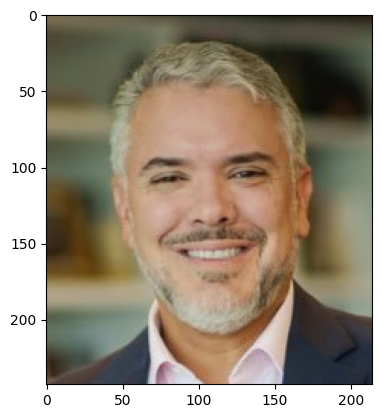

In [4]:
from matplotlib import pyplot as plt
im = cv2.imread("Duque.png")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

bboxes, landmarks = fd.detect_face(im, with_landmarks=True)



fn_src = "D:\Maestria\IA\Parcial 1\FaceSwap\Duque.png"
fns_tar = ["D:\Maestria\IA\Parcial 1\FaceSwap\petro.png"]
print(tf.__version__) 
out = fp.parse_face(im)

In [ ]:
plt.imshow(out[0])

In [ ]:
x0, y0, x1, y1, score = bboxes[0]
x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

aligned_im = align_image(im, x0, y0, x1, y1, score)

src = aligned_im

plt.imshow(im[x0:x1, y0:y1, :])

In [ ]:
src, mask, aligned_im, (x0, y0, x1, y1), landmarks = get_src_inputs(fn_src, fd, fp, idet)
tar, emb_tar = get_tar_inputs(fns_tar, fd, fv)

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
plt.figure()
plt.subplot(1,3,1)
#mask = np.resize(mask,(224,224,3))
img = Image.fromarray(mask)
plt.imshow(mask)
plt.subplot(1,3,2)
plt.imshow(src)
plt.subplot(1,3,3)
plt.imshow(tar)

In [ ]:
from models import FaceTranslationGANInferenceModel
model = FaceTranslationGANInferenceModel()
out = model.inference(src, mask, tar, emb_tar)